## COVID-19 cases in the UK

In [1]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import geopandas as gpd
from datetime import datetime
import os

Get daily indicators from Public Health England.

This data is provided as an Excel file - stream the binary data directly from this URL.

In [2]:
WORKING_PATH = os.getcwd() + '/'
DATA_PATH = os.path.dirname(os.getcwd()) + '/data/'

In [3]:
url = 'https://www.arcgis.com/sharing/rest/content/items/bc8ee90225644ef7a6f4dd1b13ea1d67/data'
# read .xlsx file from server and write to local file
r = requests.get(url, stream=True)
with open(WORKING_PATH + '~data.xlsx', 'wb') as f:
    for chunk in r.iter_content(chunk_size=1024): 
        if chunk: # filter out keep-alive new chunks
            f.write(chunk)
# read table from local file
di = pd.read_excel(WORKING_PATH + '~data.xlsx')
di.dtypes

DateVal          datetime64[ns]
TotalUKCases              int64
NewUKCases                int64
TotalUKDeaths             int64
EnglandCases              int64
ScotlandCases             int64
WalesCases                int64
NICases                   int64
dtype: object

In [4]:
# Total number of cases in England
total_cases = di['EnglandCases'].item()
# Date when last updated
dt = di['DateVal'].item()
total_cases, dt

(7973, Timestamp('2020-03-25 00:00:00'))

Get data on COVID-19 cases by area from Public Health England.

This data is provided in csv format and updated daily.

In [5]:
# load cases by Upper Tier Local Authority and Unitary Authorities
url = "https://www.arcgis.com/sharing/rest/content/items/b684319181f94875a6879bbc833ca3a6/data"
r = requests.get(url)
filename = WORKING_PATH + '~cases-data.csv'
with open(filename, 'w') as f:
    f.write(r.text)
cases_df = pd.read_csv(filename)
cases_df.head()

,GSS_CD,GSS_NM,TotalCases
0,E09000002,Barking and Dagenham,53
1,E09000003,Barnet,100
2,E08000016,Barnsley,19
3,E06000022,Bath and North East Somerset,20
4,E06000055,Bedford,7


In [6]:
cases_df[cases_df["GSS_NM"]=="Cornwall and Isles of Scilly"]

,GSS_CD,GSS_NM,TotalCases
25,E06000052,Cornwall and Isles of Scilly,37


In [7]:
cases_df[cases_df["GSS_NM"]=="Bournemouth, Christchurch and Poole"]

,GSS_CD,GSS_NM,TotalCases
10,E06000058,"Bournemouth, Christchurch and Poole",15


Get population data from local csv file (downloaded from ONS to local filesystem as static)

In [8]:
popn_df = pd.read_csv(DATA_PATH + 'UK population.csv')
popn_df.head()

,CODE,AREA,AGE GROUP,2016,2017,2018,2019,2020,2021,2022,...,2032,2033,2034,2035,2036,2037,2038,2039,2040,2041
0,E92000001,England,0-4,"3,429.0","3,382.4","3,362.4","3,354.4","3,347.5","3,335.2","3,339.1",...,"3,262.5","3,258.6","3,258.5","3,262.6","3,271.3","3,284.5","3,302.4","3,324.7","3,350.8","3,379.5"
1,E92000001,England,5-9,"3,428.3","3,498.3","3,524.0","3,539.5","3,539.3","3,525.0","3,474.5",...,"3,387.1","3,378.3","3,368.4","3,358.5","3,349.5","3,342.5","3,338.6","3,338.5","3,342.7","3,351.4"
2,E92000001,England,10-14,"3,070.3","3,165.5","3,271.5","3,353.7","3,435.3","3,501.2","3,568.3",...,"3,479.9","3,474.2","3,468.4","3,462.2","3,455.8","3,448.4","3,439.6","3,429.7","3,419.9","3,410.9"
3,E92000001,England,15-19,"3,179.4","3,115.7","3,081.9","3,073.8","3,095.1","3,158.3","3,250.3",...,"3,610.6","3,587.1","3,575.5","3,565.7","3,552.1","3,555.3","3,549.6","3,543.8","3,537.6","3,531.1"
4,E92000001,England,20-24,"3,560.0","3,530.5","3,498.8","3,460.1","3,422.3","3,365.1","3,293.0",...,"3,795.6","3,818.6","3,831.8","3,829.6","3,814.7","3,764.2","3,740.8","3,729.3","3,719.5","3,705.7"


In [9]:
# convert population data to float (removing comma thousand separators)
popn_df["2020"] = popn_df["2020"].str.replace(",","").astype(float)
# filter only 'All ages'
popn_df = popn_df[popn_df['AGE GROUP']=='All ages']
# get total population for England for later
england_popn = popn_df[popn_df['AREA']=='England']['2020']

Note Cornwall (E06000052), Isles of Scilly (E06000053), Bournemouth (E06000028), Christchurch (E07000048) & Poole (E06000029) are all separate entries in the population table - they are combined as "Cornwall and Isles of Scilly (E06000052)" and "Bournemouth, Christchurch & Poole (E06000058)" in the cases data.

In [10]:
# filter out unwanted columns, and sum Cornwall & Isles of Scilly (as E06000052), and Bournemouth, Christchurch & Poole (as E06000058)
popn_df = popn_df.replace({"CODE": {
        "E06000053": "E06000052",
        "E06000028": "E06000058",
        "E07000048": "E06000058",
        "E06000029": "E06000058"
    }}).filter(items=['CODE', '2020']).groupby('CODE').sum()
popn_df.head()

,2020
CODE,
E06000001,93.3
E06000002,141.2
E06000003,135.6
E06000004,199.1
E06000005,106.5


Import shapefile for English counties and unitary authorities (includes boundaries and centroids).

In [11]:
path = DATA_PATH + "maps/Counties_and_Unitary_Authorities_December_2016_Generalised_Clipped_Boundaries_in_England_and_Wales.shp"
gdf = gpd.read_file(path)
# check data type so we can see that this is not a normal dataframe, but a GEOdataframe - see the 'geometry' column contains shapes
gdf.dtypes

objectid         int64
ctyua16cd       object
ctyua16nm       object
ctyua16nmw      object
bng_e            int64
bng_n            int64
long           float64
lat            float64
st_areasha     float64
st_lengths     float64
geometry      geometry
dtype: object

In [12]:
# To-do: combine polygons for Bournemouth, Christchurch & Poole, and replace code with code for this combined area in cases data (E06000058)
gdf[gdf['ctyua16nm']=='Bournemouth']

,objectid,ctyua16cd,ctyua16nm,ctyua16nmw,bng_e,bng_n,long,lat,st_areasha,st_lengths,geometry
25,28,E06000028,Bournemouth,None,410069,93928,-1.85864,50.744862,4.620449e+07,47233.917784,"MULTIPOLYGON (((407576.601 97841.402, 407651.5..."


In [13]:
# include only English areas
gdf = gdf[gdf['ctyua16cd'].str.contains("E")]

In [14]:
# join population data with shapes, matching on index columns
gdf = gdf.set_index('ctyua16cd').merge(popn_df, left_index=True, right_index=True, how='left')
gdf = gdf.replace({'ctyua16nm': {'Cornwall': 'Cornwall and Isles of Scilly'}})
gdf.head()

,objectid,ctyua16nm,ctyua16nmw,bng_e,bng_n,long,lat,st_areasha,st_lengths,geometry,2020
ctyua16cd,,,,,,,,,,,
E06000001,1,Hartlepool,None,447157,531476,-1.27023,54.676159,9.359786e+07,69382.685924,"MULTIPOLYGON (((447097.001 537152.001, 447228....",93.3
E06000002,2,Middlesbrough,None,451141,516887,-1.21099,54.544670,5.387900e+07,42085.584812,"MULTIPOLYGON (((449861.900 521260.700, 449853....",141.2
E06000003,3,Redcar and Cleveland,None,464359,519597,-1.00611,54.567520,2.448388e+08,96189.660709,"MULTIPOLYGON (((455776.701 528322.499, 455684....",135.6
E06000004,4,Stockton-on-Tees,None,444937,518183,-1.30669,54.556911,2.049366e+08,115439.477112,"MULTIPOLYGON (((444126.099 528005.799, 444165....",199.1
E06000010,10,"Kingston upon Hull, City of",None,511894,431716,-0.30380,53.769791,7.145577e+07,63330.240277,"MULTIPOLYGON (((510966.600 436533.003, 511812....",262.0


In [15]:
# join cases data with shapes
cases_df.rename(columns={"GSS_NM": "ctyua16nm"}, inplace=True)
# use left join to preserve rows present in gdf but missing from cases_df (default is 'inner')
gdf = gdf.merge(cases_df, on="ctyua16nm", how="left")
gdf.head()

,objectid,ctyua16nm,ctyua16nmw,bng_e,bng_n,long,lat,st_areasha,st_lengths,geometry,2020,GSS_CD,TotalCases
0,1,Hartlepool,None,447157,531476,-1.27023,54.676159,9.359786e+07,69382.685924,"MULTIPOLYGON (((447097.001 537152.001, 447228....",93.3,E06000001,3.0
1,2,Middlesbrough,None,451141,516887,-1.21099,54.544670,5.387900e+07,42085.584812,"MULTIPOLYGON (((449861.900 521260.700, 449853....",141.2,E06000002,9.0
2,3,Redcar and Cleveland,None,464359,519597,-1.00611,54.567520,2.448388e+08,96189.660709,"MULTIPOLYGON (((455776.701 528322.499, 455684....",135.6,E06000003,10.0
3,4,Stockton-on-Tees,None,444937,518183,-1.30669,54.556911,2.049366e+08,115439.477112,"MULTIPOLYGON (((444126.099 528005.799, 444165....",199.1,E06000004,14.0
4,10,"Kingston upon Hull, City of",None,511894,431716,-0.30380,53.769791,7.145577e+07,63330.240277,"MULTIPOLYGON (((510966.600 436533.003, 511812....",262.0,E06000010,2.0


Calculate cases per 1000 population.

In [16]:
gdf.rename(columns={"2020": "Population"}, inplace=True)
gdf['density'] = gdf['TotalCases'] / gdf['Population']

Normalise using the number of cases per 1,000 population in England. 

In [17]:
total_utua_cases = gdf['TotalCases'].sum()
mean_density = total_utua_cases / england_popn

In [18]:
hot_spots = gdf.sort_values(by=['density'], ascending=False)['ctyua16nm'].head(3).to_list()

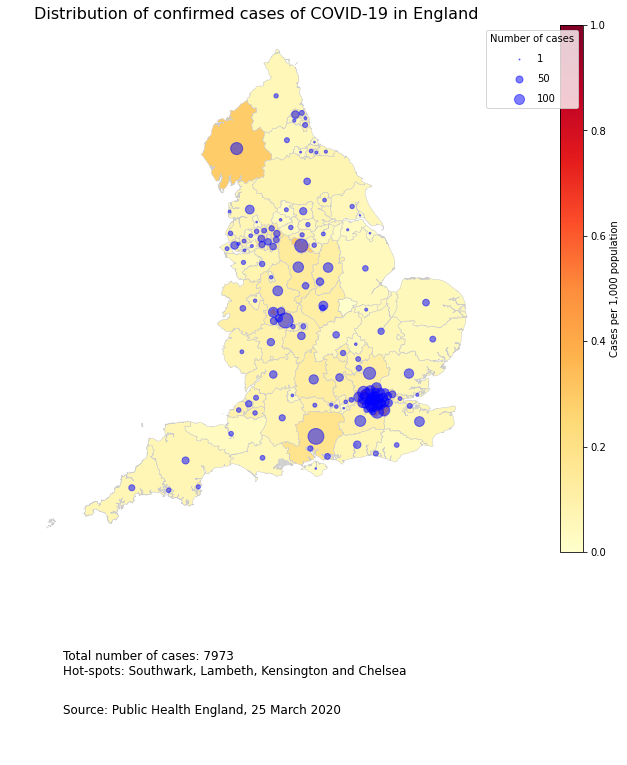

In [21]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(1, figsize=(10, 15))
# set up axes to enable positioning of the color bar.
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=1)

#set fixed range for colors
vmin, vmax = 0, 0.1

ax.axis('off')
ax.set_aspect('equal')
ax.set_title('Distribution of confirmed cases of COVID-19 in England', fontdict={'fontsize': '16', 'fontweight' : '3'})
ax.annotate('Source: Public Health England, {}'.format(dt.strftime("%d %B %Y")),
            xy=(0.1, 0.08),
            xycoords='figure fraction',
            horizontalalignment='left',
            verticalalignment='top',
            fontsize=12)
ax.annotate('Total number of cases: {}\nHot-spots: {}' \
            .format(total_cases, ", ".join(hot_spots)),
            xy=(0.1, 0.15), 
            xycoords='figure fraction', 
            horizontalalignment='left',
            verticalalignment='top',
            fontsize=12)

# ensure geometry is taken from the shapes for the base plot
gdf = gdf.set_geometry('geometry')
# base plot is a chloropleth using values from the 'density' column
base = gdf.plot(ax=ax, cax=cax, column='density', legend=True, linewidth=0.5, edgecolor="0.8",
                legend_kwds={'label': "Cases per 1,000 population"}, cmap="YlOrRd", vmin=0, vmax=1, 
                missing_kwds={"color": "lightgrey", "label": "No data"})
# calculate x,y coordinates of centroids of areas (for scatter plot)
gdf['centroids'] = gdf.centroid
# change the geometry column to 'centroids'
gdf = gdf.set_geometry('centroids')
# second layer is a scatter plot taking position from 'centroids' and marker size from 'TotalCases'
plot = gdf.plot(ax=base, color="blue", alpha=0.5, markersize=gdf["TotalCases"])

# produce legend for size of markers
for number in [1, 50, 100]:
    plt.scatter([], [], c='blue', alpha=0.5, s=number, label=str(number))
plt.legend(scatterpoints=1, frameon=True, labelspacing=1, title='Number of cases')

#plt.show()

In [943]:
fig.savefig(WORKING_PATH + 'charts/covid-19-england-{}.png'.format(dt.strftime("%Y-%B-%d")), dpi=300)

In [944]:
gdf.sort_values(by=['TotalCases'], ascending=False).filter(['TotalCases', 'ctyua16nm']).head()

,TotalCases,ctyua16nm
134,69.0,Hampshire
124,58.0,Westminster
120,58.0,Southwark
28,49.0,Kensington and Chelsea
64,43.0,Lambeth


In [945]:
# create simple html page to view daily charts

from jinja2 import Template
from os import listdir, path

# list files in target directory, excluding hidden files.
files = sorted(['/'.join(['charts', f]) for f in listdir('charts') if f[0] != '.'])

# render template
with open(WORKING_PATH + "template.html", "r") as f:
    t = Template(f.read())

with open(WORKING_PATH + "index.html", "w") as f:
    f.write(t.render(files=files))

In [946]:
# update README.md with link to latest chart
lines=[]
with open(WORKING_PATH + 'README.md', 'r') as file:
    for line in file:
        lines.append(line)

# Find and replace the target string
newdata = ''
flag = False
for line in lines:
    if flag:
        line = "![{}](charts/covid-19-england-{}.png)\n" \
            .format(dt.strftime("%d %B %Y"), dt.strftime("%Y-%B-%d"))
        flag = False
    newdata += line
    if line=="## Results\n":
        flag = True

# Write the file out again
with open(WORKING_PATH + 'README.md', 'w') as file:
    file.write(newdata)